In [1]:
from scipy.io import loadmat
import albumentations as A
import torch
import torchvision.models as models
import cv2
from albumentations.pytorch import ToTensorV2
from torch import nn
import math
import glob
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
import pandas as pd
from torch.nn.parameter import Parameter

In [2]:
class CFG:
    model_name = 'efficienet_b3'
    path_test = "../input/qmulsurvfacev1/QMUL-SurvFace/Face_Verification_Test_Set/verification_images"
    verification_neg_pairs = "./negative_pairs_names.mat"
    verification_pos_pairs = "./pos_pairs_names.mat"
    pretrain_model = "../input/effb3-arcface-no-agu-30epoch/best_model (38).pt"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes = 5319
    input_size = 112
    use_pretrained = True
    path_train = "../input/train-valid-qmul/data/train/"
    ### model config
    use_pretrained = True
    model_name = "efficientnet_b3"
    num_classes = len(glob.glob(path_train+"*"))
    embedding_size = 512
    train = True
    
    dropout = 0.3
    metric = 'arcface' # arcface, cosface , softmax 
    use_fc = True
    s = 30
    margin = 0.5
    ls_eps = 0.0
    theta_zero = 0.785

In [3]:
class AdaCos(nn.Module):
    def __init__(self, in_features, out_features, m=0.50, ls_eps=0, theta_zero=math.pi/4):
        super(AdaCos, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.theta_zero = theta_zero
        self.s = math.log(out_features - 1) / math.cos(theta_zero)
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.weight)
        # dot product
        logits = F.linear(x, W)
        # add margin
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            theta_med = torch.median(theta)
            self.s = torch.log(B_avg) / torch.cos(torch.min(self.theta_zero * torch.ones_like(theta_med), theta_med))
        output *= self.s

        return output
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output
class AddMarginProduct(nn.Module):
    r"""Implement of large margin cosine distance: :
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        s: norm of input feature
        m: margin
        cos(theta) - m
    """

    def __init__(self, in_features, out_features, s=30.0, m=0.40):
        super(AddMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

class LiArcFace(nn.Module):
    def __init__(self, in_features, out_features, m=0.4, s=64.0):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.xavier_normal_(self.weight)
        self.m = m
        self.s = s

    def forward(self, input, label):
        W = F.normalize(self.weight)
        input = F.normalize(input)
        cosine = input @ W.t()
        theta = torch.acos(cosine)
        m = torch.zeros_like(theta)
        m.scatter_(1, label.view(-1, 1), self.m)
        scale = -2 * self.s / math.pi
        return self.s + scale * (theta + m)

In [4]:
class Model(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b3',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 metric='softmax',
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=False):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param metric: One of ('arcface', 'cosface', 'softmax')
        """
        super(Model, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=True)
#         self.backbone.load_state_dict(torch.load(CFG.orginal_pretrain_model, map_location=CFG.device))
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  nn.AdaptiveAvgPool2d(1)
            
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.metric = metric
        if metric == 'arcface':
            self.final = ArcMarginProduct(final_in_features, n_classes,
                                          s=s, m=margin, easy_margin=False, ls_eps=ls_eps)
        elif metric == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif metric == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        elif metric == 'LiArcFace':
            print("LiArcFace")
            self.final = LiArcFace(final_in_features, n_classes)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x, label):
        feature = self.extract_feat(x)
        if self.metric in ('arcface', 'cosface', 'adacos','LiArcFace'):
            logits = self.final(feature, label)
        else:
            logits = self.final(feature)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)

        return x

In [5]:
class FocalLoss(torch.nn.Module):

    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [6]:
!cp "../input/qmulsurvfacev1/QMUL-SurvFace/Face_Verification_Test_Set/negative_pairs_names.mat" "negative_pairs_names.mat"
!cp "../input/qmulsurvfacev1/QMUL-SurvFace/Face_Verification_Test_Set/positive_pairs_names.mat" "positive_pairs_names.mat"
neg_pairs = loadmat("./negative_pairs_names.mat")['negative_pairs_names']
pos_pairs = loadmat("./positive_pairs_names.mat")['positive_pairs_names']

In [7]:
# !rm "./neg_pairs.csv"
# !rm "./pos_pairs.csv"

In [8]:
model = Model(**{
            'n_classes':CFG.num_classes,
            'model_name':CFG.model_name,
            'use_fc':CFG.use_fc,
            'fc_dim':CFG.embedding_size,
            'dropout':CFG.dropout,
            'metric':CFG.metric,
            's':CFG.s,
            'margin':CFG.margin,
            'ls_eps':CFG.ls_eps,
            'theta_zero':CFG.theta_zero,
            'pretrained':True
        }
)
if CFG.pretrain_model is not None:
    print("load pretrain")
    checkpoint = torch.load(CFG.pretrain_model,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])    
    
trans = A.Compose([
        A.Resize(CFG.input_size, CFG.input_size),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        A.pytorch.transforms.ToTensorV2()
])

model.to(CFG.device)
model.eval()
for name in ['neg_pairs','pos_pairs']:
    print("phase: ", name)
    time = 0
    sum_ = 0
    result = []
    for pairs in eval(name):
        img1= CFG.path_test+"/"+pairs[0][0]
        img2= CFG.path_test+"/"+pairs[1][0]

        sample1 = cv2.imread(img1)
        sample1= cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB)
        sample2 = cv2.imread(img2)
        sample2= cv2.cvtColor(sample2, cv2.COLOR_BGR2RGB)

        sample1 = trans(image=sample1)['image'].to(CFG.device)
        sample2 = trans(image=sample2)['image'].to(CFG.device)

        embeding1 = model.extract_feat(sample1[None,...])
        embeding2 = model.extract_feat(sample2[None,...])

        score = torch.nn.functional.cosine_similarity(embeding1, embeding2).detach().cpu().numpy()[0]
        print(score)
        result.append(score)
        time+=1
    pd.DataFrame({'result':result}).to_csv(name+".csv")

Building Model Backbone for efficientnet_b3 model


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


load pretrain
phase:  neg_pairs
0.026718622
0.034975
0.14529175
0.036810365
-0.01721258
0.002365143
-0.1259393
0.076674476
-0.0077125654
0.054388374
0.02441825
-0.033887547
-0.23017275
0.036082942
-0.028455053
-0.11728549
-0.005691015
0.11869384
-0.10209815
-0.04877167
-0.07536276
0.12630141
0.07921328
0.0011792476
-0.08368147
-0.056488015
-0.07678758
0.04852551
-0.002965891
0.022075146
0.027620256
-0.06499102
-0.0045158355
-0.08739471
-0.13535874
0.0036223405
-0.14405446
0.0769893
-0.15686996
-0.0051990724
0.096465506
-0.051355414
0.011512451
-0.03527154
-0.04446057
-0.12401404
-0.05316416
-0.051053062
-0.0020507844
0.12489217
-0.0049503595
0.00238231
-0.01025387
0.1594149
0.16010033
0.08613052
-0.023340454
0.2113046
-0.0010310112
-0.098909974
0.03205538
-0.11317756
-0.106336445
0.04895394
-0.13722517
-0.0012241005
0.038728323
0.028816544
0.03193407
0.051477425
-0.13506934
-0.015156646
-0.04572433
-0.09745101
-0.050743796
0.10281971
-0.14982875
0.15722287
0.042753883
-0.026165579
-0.0

In [9]:
import pandas as pd
import numpy as np

In [10]:
initial_threshold = 1.1
range_ = 0.9
step = 0.001
thresholds = []

In [11]:
neg = pd.read_csv("neg_pairs.csv")
pos = pd.read_csv("pos_pairs.csv")

In [12]:
def calculate_accuracy(list_positive_scores, list_negative_scores):
    temp_accuracy = 0
    initial_threshold = 1.1;
    range = 0.9;
    step = 0.001;
    optimial_threshold = 1.1
    optimal_threshold = 0
    thresholds = np.arange(initial_threshold-range_, initial_threshold+range_, step=0.001)
    for threshold in thresholds:
        current_accuracy_pos = [score for score in list_positive_scores if score > threshold]
        current_accuracy_neg = [score for score in list_negative_scores if score < threshold]
        current_accuracy = (len(current_accuracy_neg) + len(current_accuracy_pos))/(len(list_negative_scores) + len(list_positive_scores))
        if current_accuracy > temp_accuracy:
            temp_accuracy = current_accuracy
            optimal_threshold = threshold
    return optimal_threshold, temp_accuracy

In [13]:
optimal_threshold, temp_accuracy = calculate_accuracy(pos['result'].values.tolist(),neg['result'].values.tolist())
print(optimal_threshold, temp_accuracy)

0.20000000000000007 0.7902255639097744


In [14]:
pos['result'].values.tolist()

[0.4798935949802399,
 0.11330568790435792,
 0.2452244013547897,
 0.3309420943260193,
 0.3321897983551025,
 0.20139099657535556,
 0.179782435297966,
 0.2702288627624512,
 0.10993405431509018,
 0.060299184173345566,
 0.4009854197502136,
 0.050982341170310974,
 0.28135353326797485,
 0.11326688528060913,
 0.3164277970790863,
 0.4959917962551117,
 0.7372902035713196,
 -0.10082504153251648,
 0.2324313074350357,
 0.5600675940513611,
 0.0951000675559044,
 0.07004605978727341,
 0.21107982099056244,
 0.5066010951995851,
 0.14374999701976776,
 0.036392901092767715,
 0.4272983074188232,
 0.32524025440216064,
 -0.06472796201705933,
 0.3749861121177673,
 0.9098835587501526,
 0.12768088281154633,
 0.4131439328193665,
 0.7838388681411743,
 0.4490015804767609,
 0.1483379602432251,
 0.21506115794181824,
 0.4435345232486725,
 0.12154313176870345,
 0.3137754201889038,
 0.4389585256576538,
 0.8991532921791077,
 0.22405728697776794,
 0.3081742525100708,
 5.99208897256176e-06,
 0.34718528389930725,
 0.162509

In [15]:
list_negative_scores = neg['result'].values
list_positive_scores = pos['result'].values
thresholds = []
initial_threshold=1.1
range_ = 0.9
FARs = []
TARs = []
for threshold in np.arange(initial_threshold-range_, initial_threshold+range_, step=0.001):
    current_far = len([score for score in list_negative_scores if score > threshold])/len(list_negative_scores)
    current_tar = len([score for score in list_positive_scores if score < threshold])/len(list_positive_scores)
    thresholds.append(threshold)
    FARs.append(current_far)
    TARs.append(current_tar)

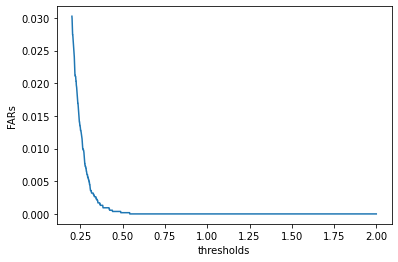

In [16]:
import matplotlib.pyplot as plt
plt.plot(thresholds, FARs)
plt.xlabel('thresholds')
plt.ylabel('FARs')
plt.show()

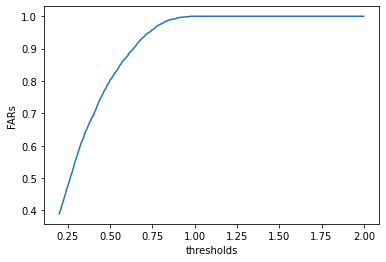

In [17]:
import matplotlib.pyplot as plt
plt.plot(thresholds, TARs)
plt.xlabel('thresholds')
plt.ylabel('FARs')
plt.show()

In [18]:
FARs = []
thresh_holds = np.arange(initial_threshold - range_, initial_threshold + range_, step)
for threshold in thresh_holds:
    current_far = (np.sum(neg.values<threshold))/(neg_pairs.shape[0])
    FARs.append(current_far)
TARs = []
for threshold in thresholds:
    current_tar = (np.sum(pos.values<threshold))/pos_pairs.shape[0]
    TARs.append(current_tar)
